## Análisis Exploratorio de Datos - Detección de Mensajes de Odio en YouTube

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Ignorar advertencias
warnings.filterwarnings('ignore')

## Configuración de visualización

In [4]:
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Cargar datos

In [6]:
print("Cargando dataset...")
df = pd.read_csv('../data/raw/youtube_hate_speech_dataset.csv')

Cargando dataset...


## 1. Información general del dataset

In [7]:
print("\n===== INFORMACIÓN GENERAL DEL DATASET =====")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe(include='all'))


===== INFORMACIÓN GENERAL DEL DATASET =====
Número de filas: 1000
Número de columnas: 15

Primeras 5 filas:
              CommentId      VideoId                                               Text  IsToxic  IsAbusive  IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist  IsSexist  IsHomophobic  IsReligiousHate  IsRadicalism
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI  If only people would just take a step back and...    False      False     False          False      False         False     False          False     False         False            False         False
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI  Law enforcement is not trained to shoot to app...     True       True     False          False      False         False     False          False     False         False            False         False
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI  \r\nDont you reckon them 'black lives matter' ...     True       True     False          False       True         False     False          

## 2. Análisis de valores faltantes

In [8]:
print("\n===== ANÁLISIS DE VALORES FALTANTES =====")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje (%)': missing_percent
})
print(missing_df[missing_df['Valores Faltantes'] > 0])


===== ANÁLISIS DE VALORES FALTANTES =====
Empty DataFrame
Columns: [Valores Faltantes, Porcentaje (%)]
Index: []


In [9]:
# Si no hay valores faltantes
if missing_df['Valores Faltantes'].sum() == 0:
    print("No hay valores faltantes en el dataset.")

No hay valores faltantes en el dataset.


## 3. Distribución de etiquetas

In [10]:
print("\n===== DISTRIBUCIÓN DE ETIQUETAS =====")
label_columns = [col for col in df.columns if col.startswith('Is')]
label_counts = df[label_columns].sum().sort_values(ascending=False)
label_percentages = (label_counts / len(df) * 100).round(2)

label_distribution = pd.DataFrame({
    'Cantidad': label_counts,
    'Porcentaje (%)': label_percentages
})
print(label_distribution)


===== DISTRIBUCIÓN DE ETIQUETAS =====
                 Cantidad  Porcentaje (%)
IsToxic               462            46.2
IsAbusive             353            35.3
IsProvocative         161            16.1
IsHatespeech          138            13.8
IsRacist              125            12.5
IsObscene             100            10.0
IsThreat               21             2.1
IsReligiousHate        12             1.2
IsNationalist           8             0.8
IsSexist                1             0.1
IsHomophobic            0             0.0
IsRadicalism            0             0.0


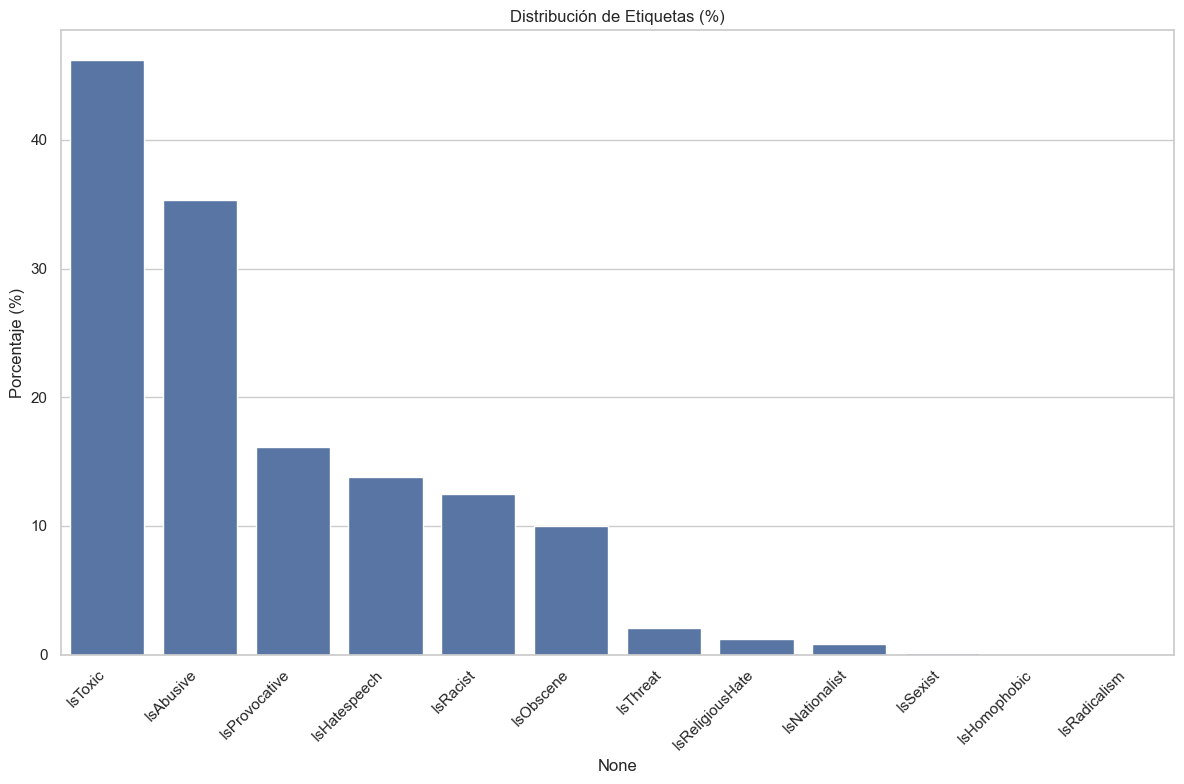

In [13]:
# Visualizar distribución de etiquetas
plt.figure(figsize=(12, 8))
sns.barplot(x=label_distribution.index, y='Porcentaje (%)', data=label_distribution)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Etiquetas (%)')
plt.tight_layout()
plt.savefig('../docs/figures/label_distribution.png')
plt.show()

## 4. Análisis de co-ocurrencia de etiquetas


===== ANÁLISIS DE CO-OCURRENCIA DE ETIQUETAS =====


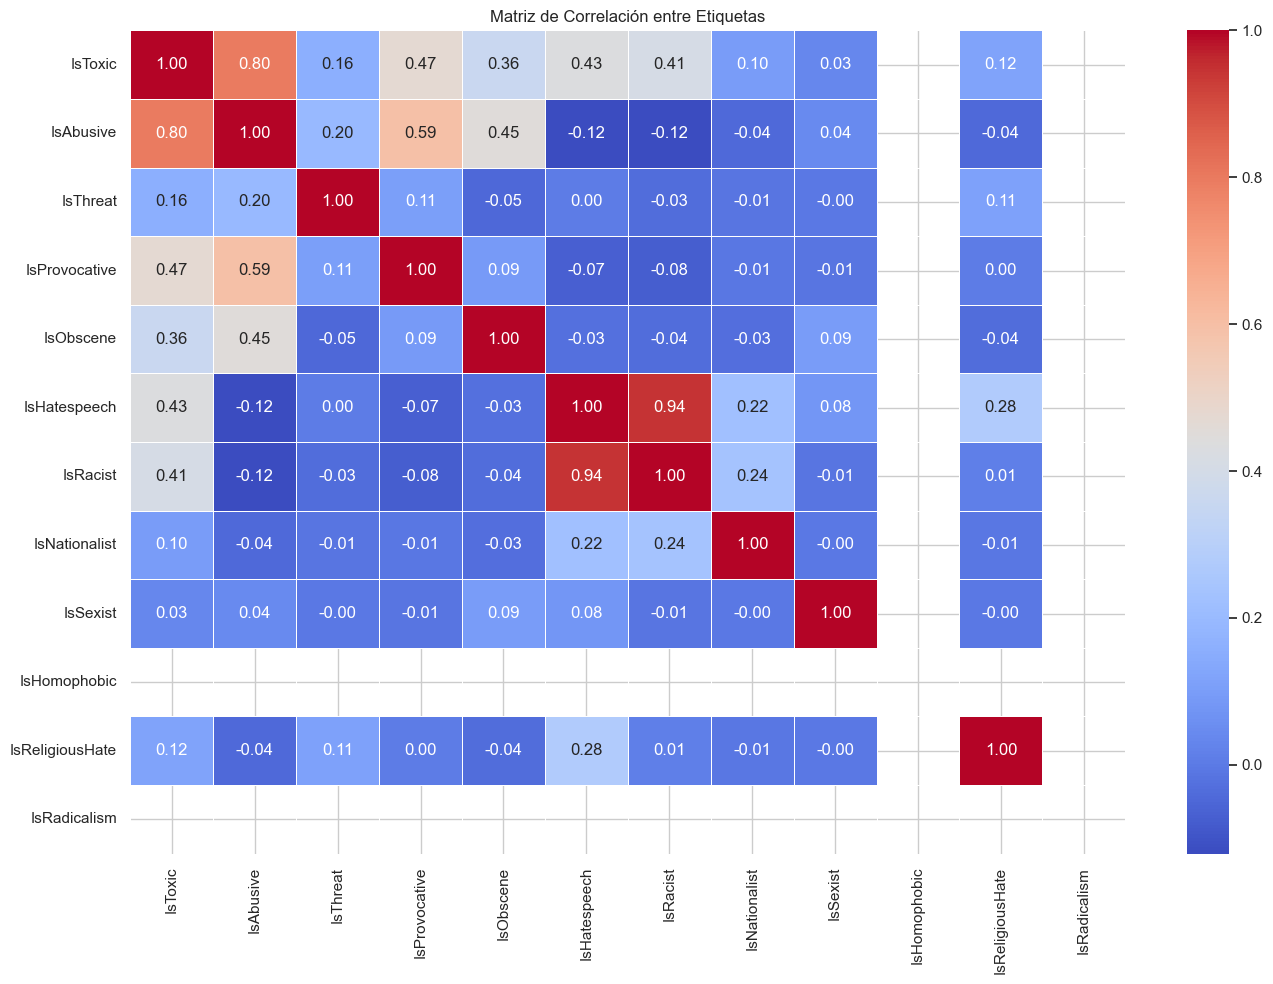

In [14]:
print("\n===== ANÁLISIS DE CO-OCURRENCIA DE ETIQUETAS =====")
correlation_matrix = df[label_columns].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Matriz de Correlación entre Etiquetas')
plt.tight_layout()
plt.savefig('../docs/figures/label_correlation.png')
plt.show()

## 5. Análisis de texto


===== ANÁLISIS DE TEXTO =====
Longitud promedio de comentarios: 185.99 caracteres
Número promedio de palabras por comentario: 33.78


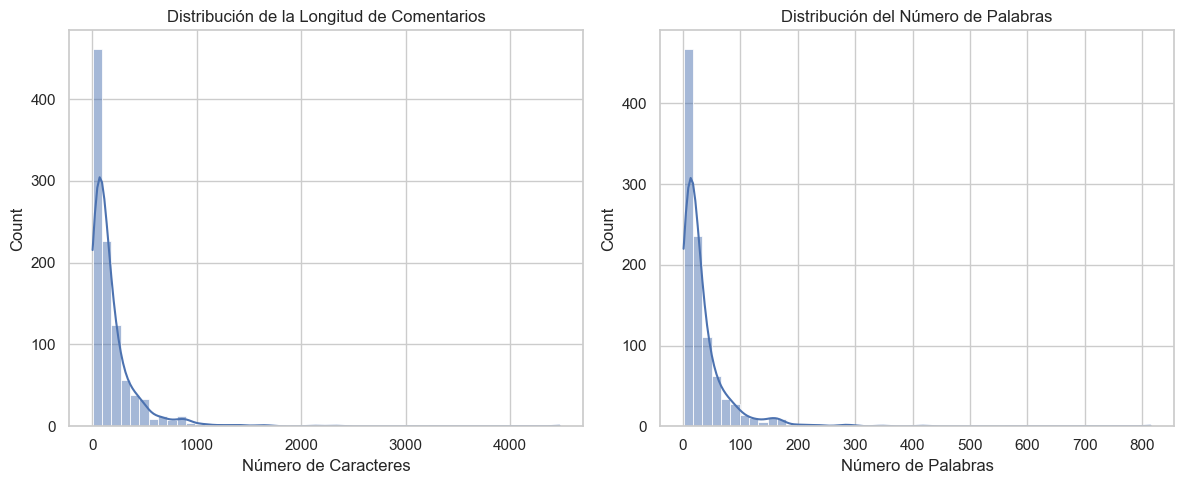

In [15]:
print("\n===== ANÁLISIS DE TEXTO =====")
# Longitud de los comentarios
df['text_length'] = df['Text'].apply(len)
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))

print(f"Longitud promedio de comentarios: {df['text_length'].mean():.2f} caracteres")
print(f"Número promedio de palabras por comentario: {df['word_count'].mean():.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribución de la Longitud de Comentarios')
plt.xlabel('Número de Caracteres')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribución del Número de Palabras')
plt.xlabel('Número de Palabras')
plt.tight_layout()
plt.savefig('../docs/figures/text_length_distribution.png')
plt.show()

## 6. Comparación de longitud entre comentarios tóxicos y no tóxicos


===== COMPARACIÓN DE LONGITUD ENTRE COMENTARIOS TÓXICOS Y NO TÓXICOS =====
Longitud promedio de comentarios tóxicos: 189.85 caracteres
Longitud promedio de comentarios no tóxicos: 182.67 caracteres


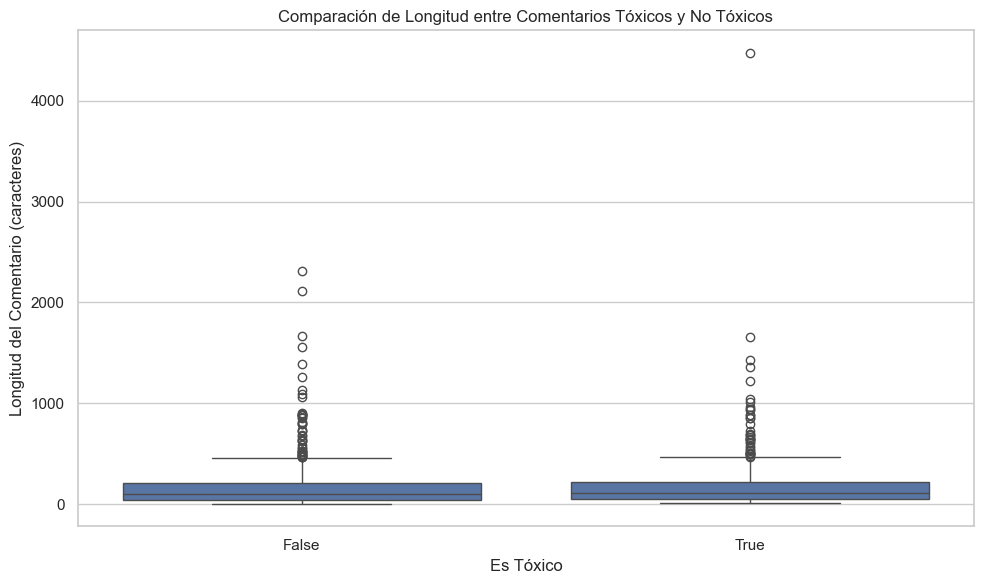

In [16]:
print("\n===== COMPARACIÓN DE LONGITUD ENTRE COMENTARIOS TÓXICOS Y NO TÓXICOS =====")
toxic_comments = df[df['IsToxic'] == True]
non_toxic_comments = df[df['IsToxic'] == False]

print(f"Longitud promedio de comentarios tóxicos: {toxic_comments['text_length'].mean():.2f} caracteres")
print(f"Longitud promedio de comentarios no tóxicos: {non_toxic_comments['text_length'].mean():.2f} caracteres")

plt.figure(figsize=(10, 6))
sns.boxplot(x='IsToxic', y='text_length', data=df)
plt.title('Comparación de Longitud entre Comentarios Tóxicos y No Tóxicos')
plt.xlabel('Es Tóxico')
plt.ylabel('Longitud del Comentario (caracteres)')
plt.tight_layout()
plt.savefig('../docs/figures/toxic_vs_nontoxic_length.png')
plt.show()

## 7. Distribución de videos


===== DISTRIBUCIÓN DE VIDEOS =====
Número de videos únicos: 13

Distribución de comentarios por video:
       VideoId  Número de Comentarios  Porcentaje (%)
0  9pr1oE34bIM                    274            27.4
1  04kJtp6pVXI                    172            17.2
2  cT14IbTDW2c                    146            14.6
3  dG7mZQvaQDk                    112            11.2
4  TZxEyoplYbI                    104            10.4
5  bUgKZMSxr3E                     39             3.9
6  8HB18hZrhXc                     38             3.8
7  4rCweDxDqdw                     37             3.7
8  Dt9-byUhPdg                     34             3.4
9       #NAME?                     16             1.6


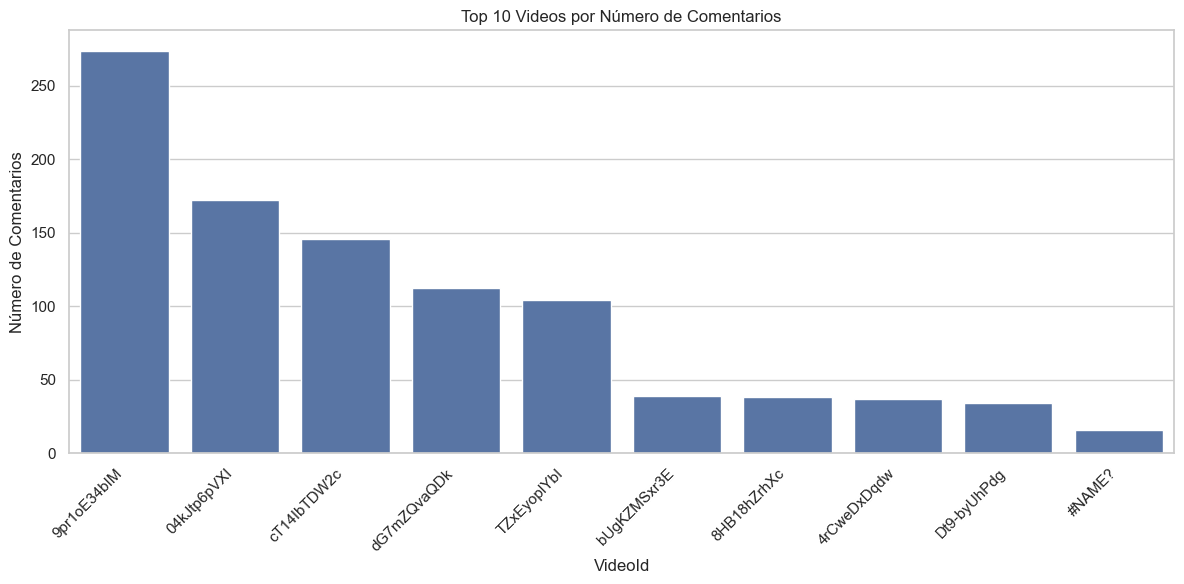

In [17]:
print("\n===== DISTRIBUCIÓN DE VIDEOS =====")
video_counts = df['VideoId'].value_counts()
print(f"Número de videos únicos: {len(video_counts)}")
print("\nDistribución de comentarios por video:")
video_distribution = pd.DataFrame({
    'VideoId': video_counts.index,
    'Número de Comentarios': video_counts.values,
    'Porcentaje (%)': (video_counts.values / len(df) * 100).round(2)
})
print(video_distribution.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='VideoId', y='Número de Comentarios', data=video_distribution.head(10))
plt.title('Top 10 Videos por Número de Comentarios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../docs/figures/videos_distribution.png')
plt.show()

## 8. Análisis de palabras más comunes

In [18]:
print("\n===== ANÁLISIS DE PALABRAS MÁS COMUNES =====")
# Descargar stopwords si es necesario
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Función para preprocesar texto"""
    # Convertir a minúsculas
    text = str(text).lower()
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Eliminar stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words

# Análisis de palabras en comentarios tóxicos
toxic_words = []
for text in toxic_comments['Text']:
    toxic_words.extend(preprocess_text(text))

toxic_word_counter = Counter(toxic_words)
print("\nPalabras más comunes en comentarios tóxicos:")
print(pd.DataFrame(toxic_word_counter.most_common(20), columns=['Palabra', 'Frecuencia']))

# Análisis de palabras en comentarios no tóxicos
non_toxic_words = []
for text in non_toxic_comments['Text']:
    non_toxic_words.extend(preprocess_text(text))

non_toxic_word_counter = Counter(non_toxic_words)
print("\nPalabras más comunes en comentarios no tóxicos:")
print(pd.DataFrame(non_toxic_word_counter.most_common(20), columns=['Palabra', 'Frecuencia']))


===== ANÁLISIS DE PALABRAS MÁS COMUNES =====

Palabras más comunes en comentarios tóxicos:
    Palabra  Frecuencia
0     black         130
1    people         127
2       get          79
3     white          76
4      like          75
5    police          72
6      dont          57
7     would          57
8     brown          50
9      fuck          50
10     shot          48
11     shit          44
12      one          39
13  officer          38
14      cop          37
15      man          35
16     cops          34
17      guy          33
18  fucking          33
19   blacks          32

Palabras más comunes en comentarios no tóxicos:
    Palabra  Frecuencia
0    people         129
1     black         116
2    police         103
3      like          76
4       get          64
5     would          61
6   officer          59
7     white          59
8     video          58
9     brown          54
10     dont          49
11      cop          49
12     shot          44
13      one        

## 9. Resumen y conclusiones

In [19]:
print("\n===== RESUMEN Y CONCLUSIONES =====")
print(f"- Dataset con {df.shape[0]} comentarios de YouTube.")
print(f"- {df['IsToxic'].sum()} comentarios marcados como tóxicos ({df['IsToxic'].mean() * 100:.2f}%).")
print(f"- Las categorías más comunes de toxicidad son: {', '.join(label_distribution.index[:3])}.")
print(f"- La longitud promedio de los comentarios es de {df['text_length'].mean():.2f} caracteres.")
print(f"- Hay {len(video_counts)} videos únicos en el dataset.")
print(f"- Existe un desbalance significativo en las clases, especialmente en: {', '.join(label_distribution[label_distribution['Porcentaje (%)'] < 5].index)}.")


===== RESUMEN Y CONCLUSIONES =====
- Dataset con 1000 comentarios de YouTube.
- 462 comentarios marcados como tóxicos (46.20%).
- Las categorías más comunes de toxicidad son: IsToxic, IsAbusive, IsProvocative.
- La longitud promedio de los comentarios es de 185.99 caracteres.
- Hay 13 videos únicos en el dataset.
- Existe un desbalance significativo en las clases, especialmente en: IsThreat, IsReligiousHate, IsNationalist, IsSexist, IsHomophobic, IsRadicalism.
